# EfficientB7 Plant Pathology
## Loading the libraries

In [3]:
import math, re, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa

## Enabling the TPU

In [4]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Loading data

In [5]:
# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
# Configuration
NUM_CLASSES=6
EPOCHS = 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 600

In [6]:
GCS_DS_PATH

'gs://kds-b2f1c46aa4084b0f892aace3caebbd3ec544a570e3257107998152f4'

In [7]:
!gsutil ls $GCS_DS_PATH

gs://kds-b2f1c46aa4084b0f892aace3caebbd3ec544a570e3257107998152f4/sample_submission.csv
gs://kds-b2f1c46aa4084b0f892aace3caebbd3ec544a570e3257107998152f4/train.csv
gs://kds-b2f1c46aa4084b0f892aace3caebbd3ec544a570e3257107998152f4/test_images/
gs://kds-b2f1c46aa4084b0f892aace3caebbd3ec544a570e3257107998152f4/train_images/


In [8]:
train_dir="../input/plant-pathology-2021-fgvc8/train_images/"
test_dir="../input/plant-pathology-2021-fgvc8/test_images/"
df_train=pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
df_sub = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')


In [9]:
df_sub.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [10]:
df_train.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [11]:
def format_train_path(fname):
    return GCS_DS_PATH+'/train_images/'+fname

In [12]:
train_paths = df_train.image.apply(format_train_path)

Make the label encodig

In [13]:
labels = df_train['labels'].str.split(" ").apply(pd.Series, 1).stack()
labels.index = labels.index.droplevel(-1)
target_labels = pd.get_dummies(labels).groupby(level=0).sum()
target_labels.head()

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,0,0,1,0,0,0
1,1,1,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0


In [14]:
## splitting train and test dataset
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, target_labels, test_size=0.1, random_state=42)

In [15]:
STEPS_PER_EPOCH = train_paths.shape[0] // BATCH_SIZE

## Image Preprocessing

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
# reading images from the directory
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

## apply data augumentation
def data_augment(image, label=None, seed=42):
    image = tf.expand_dims(image, 0)
    image = data_augmentation(image)[0]
    seed = tf.random.experimental.stateless_split([seed,IMG_SIZE], num=1)[0, :]
    image = tf.image.stateless_random_brightness(image, max_delta=0.2, seed=seed)
    #image = tf.image.stateless_random_contrast(image,0.01,0.1, seed=seed)
    
    if label is None:
        return image
    else:
        return image, label

In [17]:
## preparing train and validation dataset
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)


#### Create function for varying learning rate

In [18]:
learning_rates=[]
def build_lrfn(lr_start=0.00001, lr_max=0.00005,lr_min=0.0000105, lr_rampup_epochs=5,lr_sustain_epochs=0, lr_exp_decay=.5):    
    lr_max = lr_max * strategy.num_replicas_in_sync
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs- lr_sustain_epochs) + lr_min
        learning_rates.append(lr)
        return lr
    return lrfn

In [19]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
EarlyStopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,verbose=True, mode="min")

## Building the model

In [20]:
from tensorflow.keras.applications import EfficientNetB7

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet import EfficientNetB7,preprocess_input
from tensorflow import cast
from tensorflow.keras import Model
from keras.layers import Input

input_shape = [IMG_SIZE, IMG_SIZE, 3]

def build_model():
    base_model = EfficientNetB7(include_top=False, input_shape=input_shape ,weights="imagenet", drop_connect_rate=0.4)
    # Freeze the pretrained weights
    for layer in base_model.layers:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True
    model = Sequential()
    model.add(layers.BatchNormalization(input_shape=input_shape))
    model.add(base_model)
    # Rebuild top
    model.add(layers.GlobalAveragePooling2D(name="avg_pool"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2, name="top_dropout1"))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred"))
    opt = Adam(lr=0.001)
    input = Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = cast(input,tf.float32)
    x=preprocess_input(x)
    x=model(x)
    final_model=Model(inputs=[input],outputs=[x])
    
    metrics=[tfa.metrics.F1Score(num_classes = 6,average = "macro", name = "f1_score"),'accuracy']
    final_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=metrics )
    return final_model

In [22]:
with strategy.scope():
    model = build_model()
model.summary()

258080768/258076736 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 600, 600, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 6)                 65489161  
Total params: 65,489,161
Trainable params: 65,173,308
Non-trainable params: 315,853
_________________________________________________________________


## Training the model

In [23]:
history=model.fit(train_dataset,steps_per_epoch=STEPS_PER_EPOCH,epochs=15,validation_data=valid_dataset,callbacks=[lr_schedule,EarlyStopping],verbose=1)

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
131/131 [==============================] - 897s 5s/step - loss: 0.7758 - f1_score: 0.1040 - accuracy: 0.1335 - val_loss: 0.5964 - val_f1_score: 0.1572 - val_accuracy: 0.2259
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
131/131 [==============================] - 201s 2s/step - loss: 0.3546 - f1_score: 0.5117 - accuracy: 0.5595 - val_loss: 0.3947 - val_f1_score: 0.3183 - val_accuracy: 0.4126
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
131/131 [==============================] - 203s 2s/step - loss: 0.1471 - f1_score: 0.8157 - accuracy: 0.8449 - val_loss: 0.3883 - val_f1_score: 0.3998 - val_accuracy: 0.4769
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
131/131 [==============================] - 201s 2s/step - loss: 0.1185 - f1_score: 0.8519 - accuracy: 0.8751 - val_loss: 0.2442 - val_f1_score: 0.7412

In [24]:
model.save("Final_Model.h5",save_format='h5')

Text(0.5, 1.0, 'Epochs Vs Learning Rate')

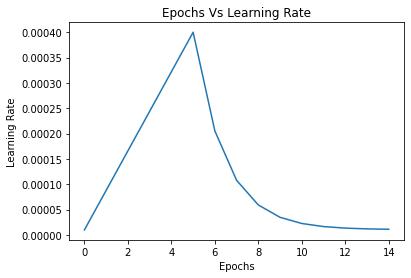

In [25]:
plt.plot(range(0,15),learning_rates)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Epochs Vs Learning Rate')